# 주요 내용
### K-Fold Cross Validation 구현 및 적용 (instead of train_test_split() function)
### -> 5-Fold * 100 Epochs 수행
### 실험 결과는 5개의 fold를 평균내어 표시
### 최종 evaluation은 전체 train, validation data를 합친 4000개로 훈련 후 test data 1000개로 수행

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['I4F02631KSM0', 'I4F07633JSI0', 'GSF09844KKS0', 'I4F03423KSR0', 'I4F05332CJH0']
50


In [4]:
# pcm to wav

import wave

for i, folder_path in enumerate(os.listdir(pcm_path)):
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(file_list_pcm):
        with open(os.path.join(pcm_path, folder_path, file_path), 'rb') as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, '{}_{}.wav'.format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['9_53.wav', '27_24.wav', '32_96.wav', '1_37.wav', '28_31.wav']
5000


In [0]:
# initialized values

import numpy as np

num_labels = 50
num_features = 100
sr = 16000
duration = 1

training_rate = 0.8
num_training_data = int(num_features * training_rate)  # 100 * 0.2 = 80
num_test_data = num_features - num_training_data # 20

training_features = np.arange(0, num_training_data, 1) # 0 to 79
# no. of test data are fixed to evaluate fairly (as use always same test data)
test_features = np.arange(num_training_data, num_features, 1) # 80 to 99

# naming
save_training_data_name = 'training_data'
save_training_labels_name = 'training_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

In [0]:
# save features as *.npz format

from scipy.io import wavfile

training_data = np.zeros((num_labels * num_training_data, duration * sr))
training_labels = np.zeros((num_labels * num_training_data))

test_data = np.zeros((num_labels * num_test_data, duration * sr))
test_labels = np.zeros((num_labels * num_test_data))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)
        
        # save training data
        if j in training_features:
            training_data[i * num_training_data + j] = samples[start:end]
            training_labels[i * num_training_data + j] = i

        # save test data
        if j in test_features:
            test_data[i * num_test_data + (j - num_training_data)] = samples[start:end]
            test_labels[i * num_test_data + (j - num_training_data)] = i

# save *.npy        
np.save("./" + save_training_data_name, training_data)
np.save("./" + save_training_labels_name, training_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

In [7]:
# load data, labels

from tensorflow.keras.utils import to_categorical

training_data = np.load(save_training_data_name + ".npy")
training_labels = np.load(save_training_labels_name + ".npy")

print('training_data.shape: {}, training_labels.shape: {}'.format(training_data.shape, training_labels.shape))

training_data.shape: (4000, 16000), training_labels.shape: (4000,)


In [0]:
# generate model as a function

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

def build_model():
    model = Sequential()
    model.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(32, 7, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(64, 7, activation = 'relu'))
    model.add(layers.MaxPooling1D(5))

    model.add(layers.Conv1D(128, 7, activation = 'relu'))
    model.add(layers.Conv1D(128, 8, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(num_labels, activation = 'softmax'))

    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [9]:
# split train & test data/labels

len_data = training_data.shape[1] # i.e. sr * duration

n_splits = 5
num_val_samples = num_training_data // n_splits # i.e. 80 * 0.2 = 16

batch_size = 80
epochs = 100

all_history = []

for i in range(n_splits):
    print('처리중인 폴드 #{}'.format(i))

    # data saperating
    partial_X_vals = [training_data[j::num_training_data] for j in range(i * num_val_samples, (i+1) * num_val_samples)]
    partial_Y_vals = [training_labels[j::num_training_data] for j in range(i * num_val_samples, (i+1) * num_val_samples)]

    partial_X_trains = [training_data[j::num_training_data] for j in range(i * num_val_samples)]
    partial_X_trains += [training_data[j::num_training_data] for j in range((i+1) * num_val_samples, num_training_data)]

    partial_Y_trains = [training_labels[j::num_training_data] for j in range(i * num_val_samples)]
    partial_Y_trains += [training_labels[j::num_training_data] for j in range((i+1) * num_val_samples, num_training_data)]

    X_train = np.concatenate(partial_X_trains, axis = 0)
    Y_train = np.concatenate(partial_Y_trains, axis = 0)
    
    X_val = np.concatenate(partial_X_vals, axis = 0)
    Y_val = np.concatenate(partial_Y_vals, axis = 0)

    print('sperating validation data arange: [{}, {}]'.format(i * num_val_samples, (i+1) * num_val_samples - 1))

    # data reshaping
    x_train = X_train.reshape(len(X_train), len_data, 1)
    x_val = X_val.reshape(len(X_val), len_data, 1) 

    y_train = to_categorical(Y_train)
    y_val = to_categorical(Y_val)

    # standarization
    mean = x_train.mean()
    x_train -= mean
    std = x_train.std()
    x_train /= std

    x_val -= mean
    x_val /= std 

    # build model
    model = build_model()
    history = model.fit(x_train, y_train,
                        validation_data = (x_val, y_val),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 0)
    
    all_history.append(history)

처리중인 폴드 #0
sperating validation data arange: [0, 15]
처리중인 폴드 #1
sperating validation data arange: [16, 31]
처리중인 폴드 #2
sperating validation data arange: [32, 47]
처리중인 폴드 #3
sperating validation data arange: [48, 63]
처리중인 폴드 #4
sperating validation data arange: [64, 79]


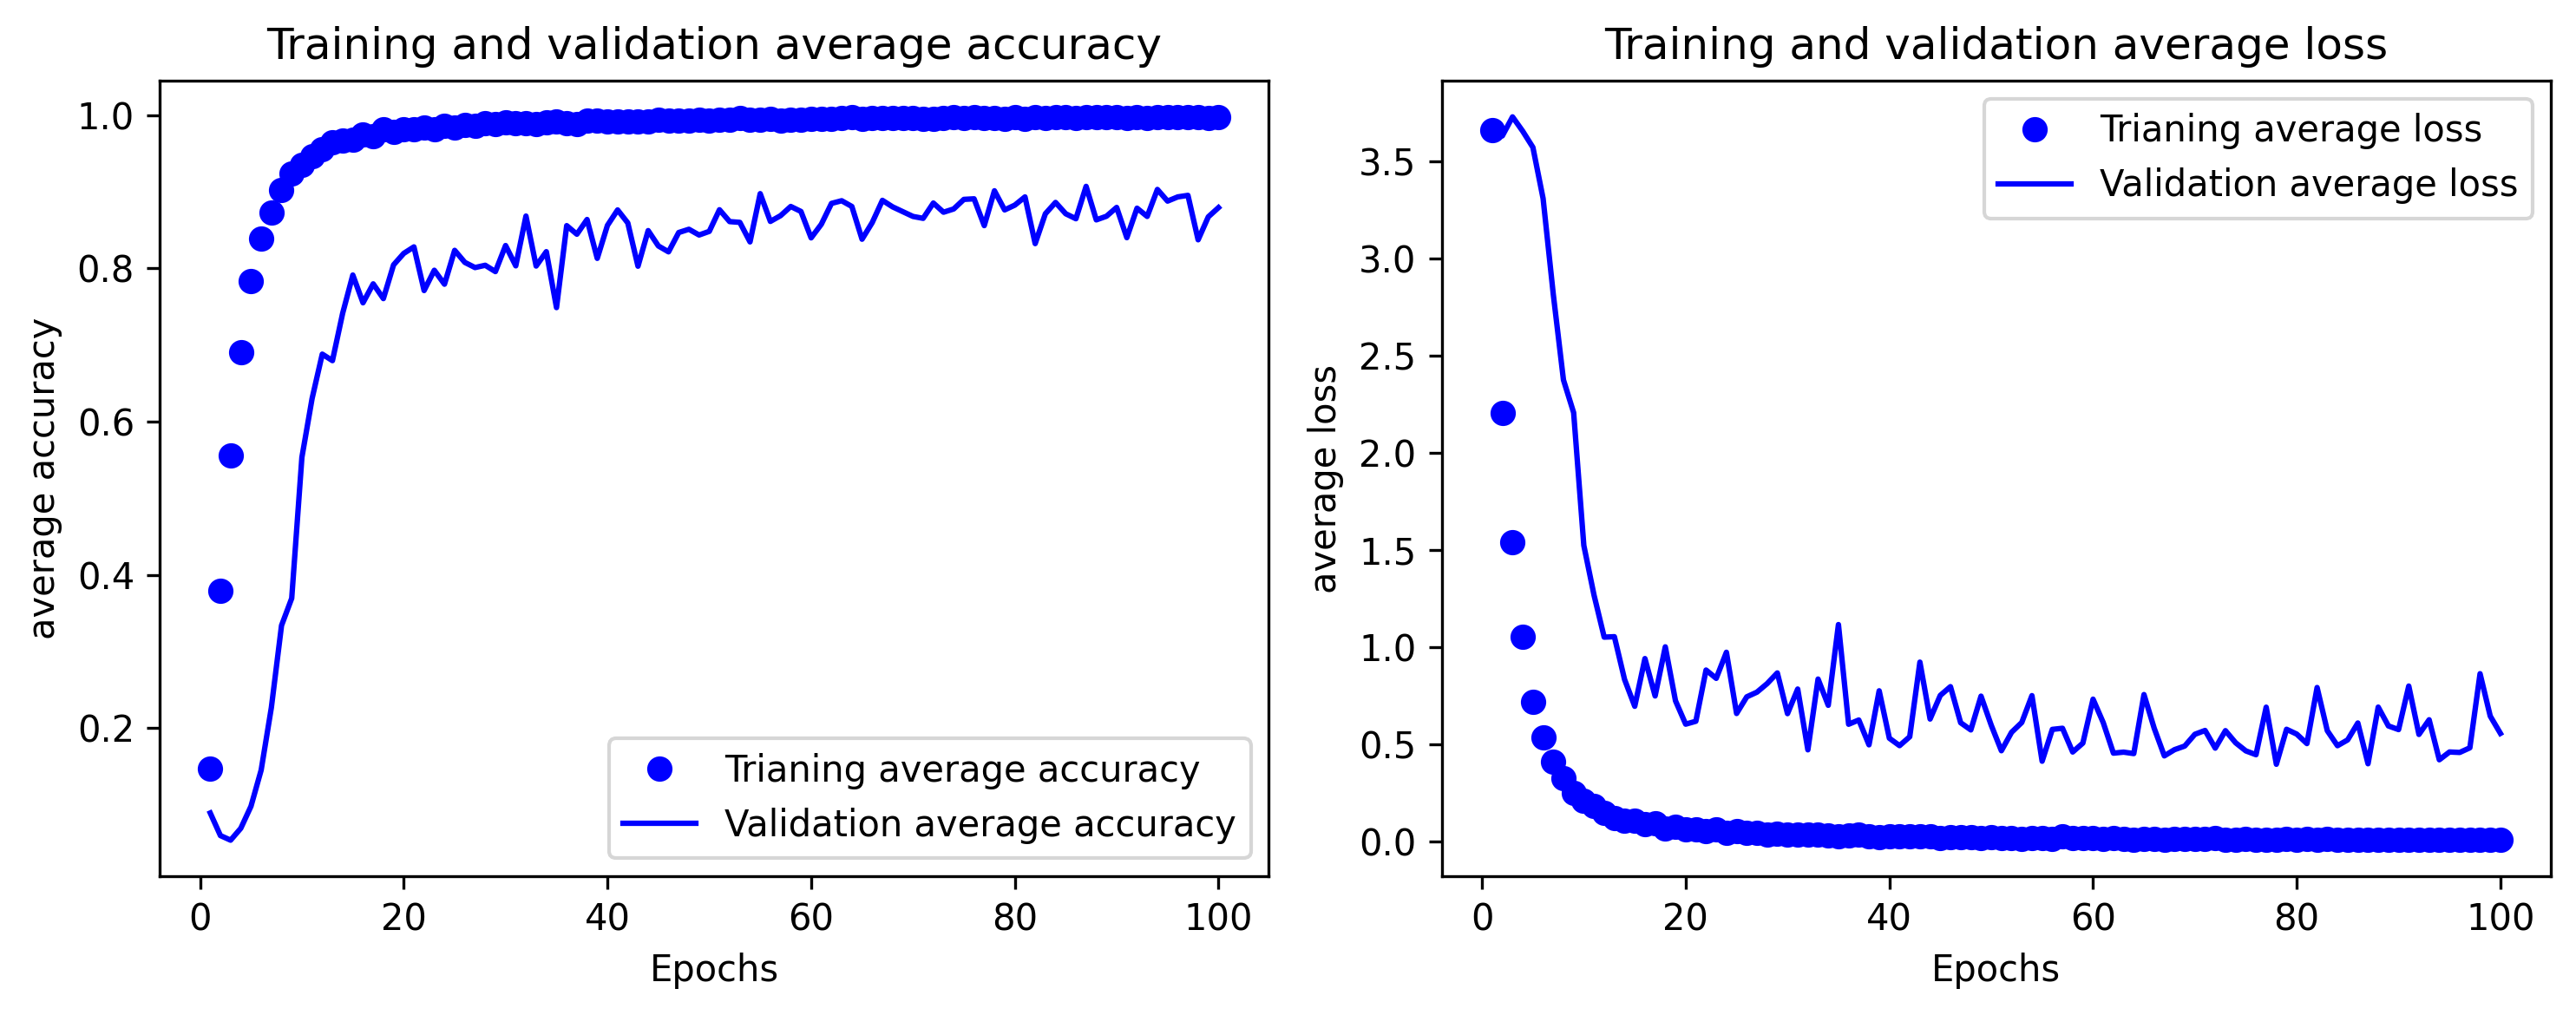

In [10]:
# plot

import matplotlib.pyplot as plt

# calculate average
acc = [all_history[i].history['accuracy'] for i in range(n_splits)]
avg_acc = [np.mean([x[i] for x in acc]) for i in range(epochs)]

val_acc = [all_history[i].history['val_accuracy'] for i in range(n_splits)]
avg_val_acc = [np.mean([x[i] for x in val_acc]) for i in range(epochs)]

loss = [all_history[i].history['loss'] for i in range(n_splits)]
avg_loss = [np.mean([x[i] for x in loss]) for i in range(epochs)]

val_loss = [all_history[i].history['val_loss'] for i in range(n_splits)]
avg_val_loss = [np.mean([x[i] for x in val_loss]) for i in range(epochs)]

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# average accuracy & average validation accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), avg_acc, 'bo', label = 'Trianing average accuracy')
plt.plot(range(1, epochs + 1), avg_val_acc, 'b', label = 'Validation average accuracy')
plt.title('Training and validation average accuracy')
plt.xlabel('Epochs')
plt.ylabel('average accuracy')
plt.legend()

# average loss & average validation loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), avg_loss, 'bo', label = 'Trianing average loss')
plt.plot(range(1, epochs + 1), avg_val_loss, 'b', label = 'Validation average loss')
plt.title('Training and validation average loss')
plt.xlabel('Epochs')
plt.ylabel('average loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# evaluate as test data

# reshaping
training_data = training_data.reshape(len(training_data), len_data, 1)
training_labels = to_categorical(training_labels)

test_data = test_data.reshape(len(test_data), len_data, 1)
test_labels = to_categorical(test_labels)

# standarization
mean = training_data.mean()
training_data -= mean
std = training_data.std()
training_data /= std

test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 16000, 1), test_labels.shape: (1000, 50)


In [12]:
# build model

batch_size = 80
epochs = 100

model = build_model()
model.fit(training_data, training_labels,
          epochs = epochs, batch_size = batch_size, verbose = 0)

# evaluate
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 0s 13ms/step - loss: 0.3305 - accuracy: 0.9210
test loss, test acc: [0.3304527699947357, 0.9210000038146973]
